In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import glob
import csv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json

# Preprocessing functions
def merge_csi_label(csifile, labelfile, win_len=10, thrshd=0.6, step=2):
    activity = []
    with open(labelfile, 'r') as labelf:
        reader = csv.reader(labelf)
        for line in reader:
            label = line[0]
            activity.append(0 if label == 'NoActivity' else 1)
    activity = np.array(activity)
    csi = []
    with open(csifile, 'r') as csif:
        reader = csv.reader(csif)
        for line in reader:
            line_array = np.array([float(v) for v in line[1:52]])
            csi.append(line_array[np.newaxis, ...])
    csi = np.concatenate(csi, axis=0)
    assert csi.shape[0] == activity.shape[0]

    index = 0
    feature = []
    while index + win_len <= csi.shape[0]:
        cur_activity = activity[index:index+win_len]
        if np.sum(cur_activity) < thrshd * win_len:
            index += step
            continue
        cur_feature = csi[index:index+win_len, :][np.newaxis, ...]
        feature.append(cur_feature)
        index += step
    return np.concatenate(feature, axis=0)

def extract_csi_by_label(raw_folder, label, labels, win_len=10, thrshd=0.6, step=2):
    data_path_pattern = os.path.join(raw_folder, label + '*_data.csv')
    input_csv_files = sorted(glob.glob(data_path_pattern))
    annot_csv_files = [os.path.join(raw_folder, os.path.basename(f).replace('_data', '_label')) for f in input_csv_files]
    
    feature = []
    for csi_file, label_file in zip(input_csv_files, annot_csv_files):
        if os.path.exists(label_file):
            feature.append(merge_csi_label(csi_file, label_file, win_len, thrshd, step))
    feat_arr = np.concatenate(feature, axis=0)
    feat_label = np.zeros((feat_arr.shape[0], len(labels)))
    feat_label[:, labels.index(label)] = 1
    return feat_arr, feat_label

def train_valid_split(data, train_portion=0.80, seed=89):
    np.random.seed(seed)
    x_train, y_train, x_valid, y_valid = [], [], [], []
    for i, (x, y) in enumerate(data):
        indices = np.random.permutation(len(x))
        split = int(train_portion * len(x))
        x_train.append(x[indices[:split]])
        y_train.append(y[indices[:split]])
        x_valid.append(x[indices[split:]])
        y_valid.append(y[indices[split:]])
    return (
        np.concatenate(x_train), np.concatenate(y_train),
        np.concatenate(x_valid), np.concatenate(y_valid)
    )


In [2]:
# Attention Layer in PyTorch
class AttentionLayer(nn.Module):
    def __init__(self, num_state, input_dim):
        super(AttentionLayer, self).__init__()
        self.kernel = nn.Linear(input_dim, num_state)
        self.bias = nn.Parameter(torch.zeros(num_state))
        self.prob_kernel = nn.Linear(num_state, 1, bias=False)
    
    def forward(self, x):
        attention_state = torch.tanh(self.kernel(x) + self.bias)
        logits = self.prob_kernel(attention_state).squeeze(-1)
        probs = torch.softmax(logits, dim=1)
        weighted_feature = (x * probs.unsqueeze(-1)).sum(dim=1)
        return weighted_feature

In [3]:
# # CSI Model
# class CSIModel(nn.Module):
#     def __init__(self, input_dim=51, lstm_units=200, atten_units=500, output_dim=4):
#         super(CSIModel, self).__init__()
#         self.bilstm = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
#         self.attention = AttentionLayer(atten_units, lstm_units * 2)
#         self.fc = nn.Linear(lstm_units * 2, output_dim)
    
#     def forward(self, x):
#         lstm_out, _ = self.bilstm(x)
#         att_out = self.attention(lstm_out)
#         return self.fc(att_out)

In [3]:
import torch
import torch.nn as nn

class CSIModel(nn.Module):
    def __init__(self, input_dim=51, lstm_units=150, atten_units=300, output_dim=4):
        super(CSIModel, self).__init__()
        self.bilstm1 = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(lstm_units * 2, lstm_units, batch_first=True, bidirectional=True)  # Additional LSTM layer
        self.attention = AttentionLayer(atten_units, lstm_units * 2)
        self.fc = nn.Linear(lstm_units * 2, output_dim)
    
    def forward(self, x):
        lstm_out1, _ = self.bilstm1(x)  # Output from the first LSTM layer
        lstm_out2, _ = self.bilstm2(lstm_out1)  # Output from the second LSTM layer
        att_out = self.attention(lstm_out2)
        return self.fc(att_out)


In [4]:
# Load and preprocess data
raw_data_folder = './processed/los/'
labels = ["fall", "run", "stand", "walk"]
data = [extract_csi_by_label(raw_data_folder, label, labels) for label in labels]

x_train, y_train, x_valid, y_valid = train_valid_split(data)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(x_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [6]:
# # Model initialization
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"GPU in use: {device}")

# model = CSIModel(output_dim=len(labels)).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-5)

# history = {"epoch": [], "train_accuracy": [], "train_loss": []}


# # Training loop
# for epoch in range(40):
#     model.train()
#     total_loss, correct, total = 0, 0, 0

#     for x_batch, y_batch in train_loader:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_pred = model(x_batch)

#         loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
#         correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
#         total += y_batch.size(0)

#     history["epoch"].append(epoch + 1)
#     history["train_loss"].append(total_loss / len(train_loader))
#     history["train_accuracy"].append(correct / total)

#     print(f"Epoch {epoch+1}, Accuracy: {correct / total:.4f}, Loss: {total_loss / len(train_loader):.4f}")

# torch.save(model.state_dict(), "./pytorch_training/los/model/model_29.pth")
# print("Model saved successfully.")
# history_save_path = "./pytorch_training/los/model/training_history_29.json"
# with open(history_save_path, "w") as f:
#     json.dump(history, f)
# print(f"Training history saved to {history_save_path}")


In [7]:
# # Load training history
# history_save_path = "./pytorch_training/los/model/training_history_29.json"
# with open(history_save_path, "r") as f:
#     history = json.load(f)

# # Extract data
# epochs = history["epoch"]
# train_loss = history["train_loss"]
# train_accuracy = history["train_accuracy"]

# plot_save_path = "./pytorch_training/los/plot/plot_29.png"

# # Plotting
# plt.figure(figsize=(12, 6))

# # Loss curve
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss, label="Training Loss", color="blue", marker=",")
# plt.title("Training Loss Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.legend()

# # Accuracy curve
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracy, label="Training Accuracy", color="green", marker=",")
# plt.title("Training Accuracy Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.legend()

# plt.savefig(plot_save_path, bbox_inches='tight')
# plt.tight_layout()
# plt.show()


In [8]:
# # Evaluation
# model.eval()
# y_true, y_pred = [], []
# with torch.no_grad():
#     for x_batch, y_batch in valid_loader:
#         x_batch = x_batch.to(device)
#         preds = model(x_batch).cpu()

#         y_true.extend(torch.argmax(y_batch, axis=1).numpy())
#         y_pred.extend(torch.argmax(preds, axis=1).numpy())

#         correct += (torch.argmax(preds, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
#         total += y_batch.size(0)

# # Confusion matrix
# cm_save_path = "./pytorch_training/los/cm/confusion_matrix_29.png"
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# fig, ax = plt.subplots(figsize=(6, 6)) 
# disp.plot(ax=ax)
# plt.savefig(cm_save_path, bbox_inches='tight')
# plt.show()

# accuracy = correct / total * 100
# print(f"Test Accuracy: {accuracy:.2f}%")

In [9]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU in use: {device}")

model = CSIModel(output_dim=len(labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

history = {"epoch": [], "train_accuracy": [], "train_loss": [], "test_accuracy": [], "test_loss": []}

# Training loop
for epoch in range(40):
    # Training phase
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation phase
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)

            loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
            total_loss += loss.item()
            correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
            total += y_batch.size(0)

    test_loss = total_loss / len(valid_loader)
    test_accuracy = correct / total

    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)

    print(f"Epoch {epoch+1}, Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, "
          f"Test Acc: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

torch.save(model.state_dict(), "./pytorch_training/los/model/model_40.pth")
print("Model saved successfully.")

history_save_path = "./pytorch_training/los/model/training_history_40.json"
with open(history_save_path, "w") as f:
    json.dump(history, f)
print(f"Training history saved to {history_save_path}")


GPU in use: cuda
Epoch 1, Train Acc: 0.4158, Train Loss: 1.2977, Test Acc: 0.5122, Test Loss: 1.1859
Epoch 2, Train Acc: 0.6184, Train Loss: 1.0154, Test Acc: 0.6905, Test Loss: 0.8444
Epoch 3, Train Acc: 0.7490, Train Loss: 0.7030, Test Acc: 0.7870, Test Loss: 0.5913
Epoch 4, Train Acc: 0.8024, Train Loss: 0.5386, Test Acc: 0.8212, Test Loss: 0.4882
Epoch 5, Train Acc: 0.8217, Train Loss: 0.4687, Test Acc: 0.8291, Test Loss: 0.4465
Epoch 6, Train Acc: 0.8342, Train Loss: 0.4286, Test Acc: 0.8385, Test Loss: 0.4135
Epoch 7, Train Acc: 0.8399, Train Loss: 0.4030, Test Acc: 0.8428, Test Loss: 0.3936
Epoch 8, Train Acc: 0.8463, Train Loss: 0.3851, Test Acc: 0.8486, Test Loss: 0.3799
Epoch 9, Train Acc: 0.8483, Train Loss: 0.3714, Test Acc: 0.8539, Test Loss: 0.3673
Epoch 10, Train Acc: 0.8527, Train Loss: 0.3596, Test Acc: 0.8531, Test Loss: 0.3551
Epoch 11, Train Acc: 0.8563, Train Loss: 0.3493, Test Acc: 0.8541, Test Loss: 0.3497
Epoch 12, Train Acc: 0.8574, Train Loss: 0.3388, Test Acc

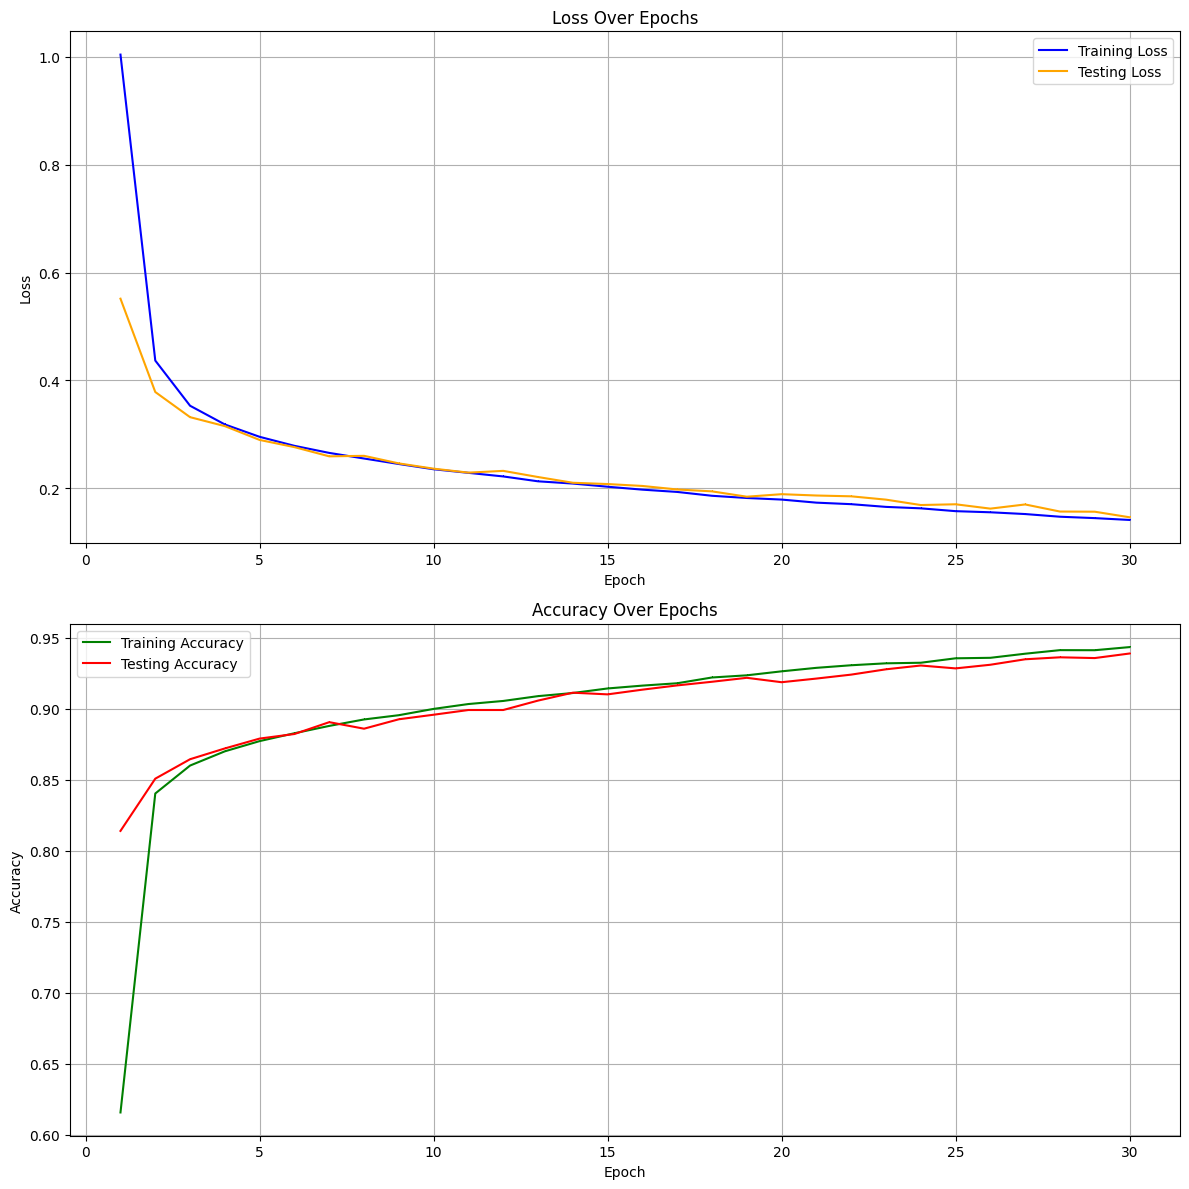

In [8]:
# Load training history
history_save_path = "./pytorch_training/los/model/training_history_32.json"
with open(history_save_path, "r") as f:
    history = json.load(f)

# Extract data
epochs = history["epoch"]
train_loss = history["train_loss"]
train_accuracy = history["train_accuracy"]
test_loss = history["test_loss"]
test_accuracy = history["test_accuracy"]

plot_save_path = "./pytorch_training/los/plot/plot_40.png"

# Plotting
plt.figure(figsize=(12, 12))

# Loss curve
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label="Training Loss", color="blue", marker=",")
plt.plot(epochs, test_loss, label="Testing Loss", color="orange", marker=",")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy curve
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy", color="green", marker=",")
plt.plot(epochs, test_accuracy, label="Testing Accuracy", color="red", marker=",")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(plot_save_path, bbox_inches="tight")
plt.show()


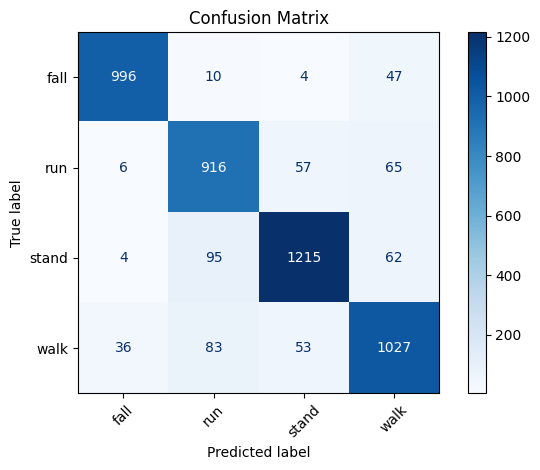

Confusion matrix saved to ./pytorch_training/los/cm/confusion_matrix_40.png


In [11]:
# Function to evaluate the model and compute the confusion matrix
def plot_confusion_matrix(model, loader, labels, device, save_path):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = model(x_batch)
            y_true.extend(torch.argmax(y_batch, axis=1).cpu().numpy())
            y_pred.extend(torch.argmax(predictions, axis=1).cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# After training is complete
confusion_matrix_save_path = "./pytorch_training/los/cm/confusion_matrix_40.png"
plot_confusion_matrix(model, valid_loader, labels, device, confusion_matrix_save_path)
print(f"Confusion matrix saved to {confusion_matrix_save_path}")


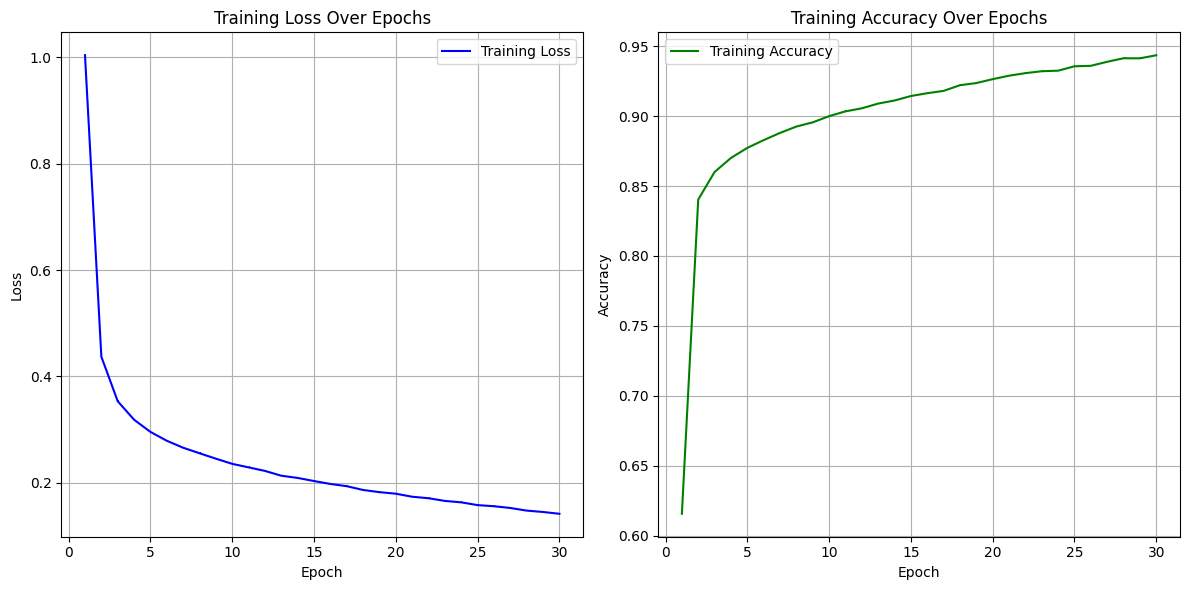

In [5]:
# Load training history
history_save_path = "./pytorch_training/los/model/training_history_32.json"
with open(history_save_path, "r") as f:
    history = json.load(f)

# Extract data
epochs = history["epoch"]
train_loss = history["train_loss"]
train_accuracy = history["train_accuracy"]

# Plot Training Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", color="blue", marker=",")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy", color="green", marker=",")
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


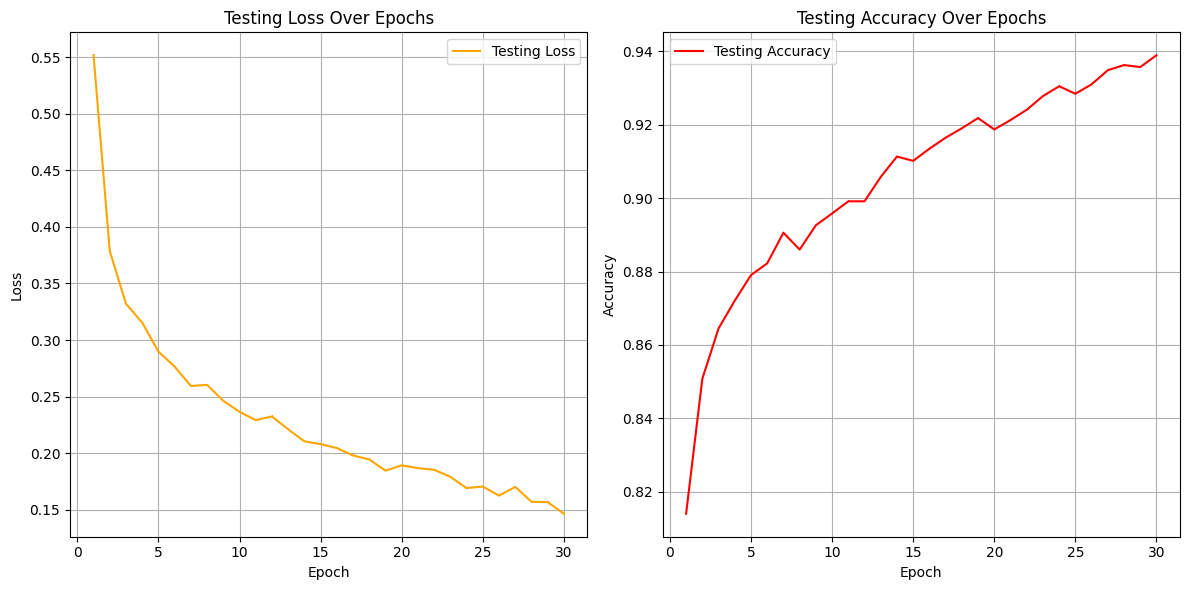

In [6]:
# Extract data
test_loss = history["test_loss"]
test_accuracy = history["test_accuracy"]

# Plot Testing Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, test_loss, label="Testing Loss", color="orange", marker=",")
plt.title("Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracy, label="Testing Accuracy", color="red", marker=",")
plt.title("Testing Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# import torch
# from torch.utils.tensorboard import SummaryWriter
# import torch.optim as optim
# import torch.nn as nn
# import json

# # Model initialization
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"GPU in use: {device}")

# # Assuming CSIModel and train_loader are already defined elsewhere
# model = CSIModel(output_dim=len(labels)).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# history = {"epoch": [], "train_accuracy": [], "train_loss": []}

# # Initialize TensorBoard writer
# log_dir = './runs/training_logs'
# writer = SummaryWriter(log_dir)

# # Training loop
# for epoch in range(80):
#     model.train()
#     total_loss, correct, total = 0, 0, 0

#     for i, (x_batch, y_batch) in enumerate(train_loader):
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_pred = model(x_batch)

#         loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
#         total += y_batch.size(0)

#         # Log metrics at each batch (optional, can adjust frequency)
#         if i % 10 == 0:  # Log every 10th batch (you can change this frequency)
#             writer.add_scalar("Loss/Train/Batch", loss.item(), epoch * len(train_loader) + i)
#             writer.add_scalar("Accuracy/Train/Batch", correct / total, epoch * len(train_loader) + i)

#     # Calculate epoch metrics
#     epoch_loss = total_loss / len(train_loader)
#     epoch_accuracy = correct / total
#     history["epoch"].append(epoch + 1)
#     history["train_loss"].append(epoch_loss)
#     history["train_accuracy"].append(epoch_accuracy)

#     # Log metrics at the end of each epoch
#     writer.add_scalar("Loss/Train/Epoch", epoch_loss, epoch)
#     writer.add_scalar("Accuracy/Train/Epoch", epoch_accuracy, epoch)

#     print(f"Epoch {epoch+1}, Accuracy: {epoch_accuracy:.4f}, Loss: {epoch_loss:.4f}")

# # Save the training history
# history_save_path = "./pytorch_training/model/training_history_8.json"
# with open(history_save_path, "w") as f:
#     json.dump(history, f)
# print(f"Training history saved to {history_save_path}")

# # Close TensorBoard writer after training
# writer.close()
# print(f"Training complete. Logs saved to {log_dir}. Use `tensorboard --logdir={log_dir}` to visualize.")


In [7]:
# Import required libraries
import torch

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./pytorch_training/los/model/model_32.pth"

# Ensure the model's architecture is defined
model = CSIModel(output_dim=len(labels))  # Replace len(labels) with the correct output dimension
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


In [8]:
from sklearn.metrics import classification_report

# Function to calculate precision and recall




def calculate_precision_recall(model, loader, labels, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = model(x_batch)
            y_true.extend(torch.argmax(y_batch, axis=1).cpu().numpy())
            y_pred.extend(torch.argmax(predictions, axis=1).cpu().numpy())

    # Calculate precision, recall, and other metrics
    report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
    print("Classification Report:")
    print(report)

# Call this function after training is complete
calculate_precision_recall(model, history, labels, device)


ValueError: too many values to unpack (expected 2)

In [9]:
from sklearn.metrics import classification_report

# Function to calculate precision and recall
def calculate_precision_recall(model, loader, labels, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 2:  # Standard case (inputs and labels)
                x_batch, y_batch = batch
            elif len(batch) > 2:  # Extra values (e.g., metadata)
                x_batch, y_batch = batch[:2]  # Take the first two elements (inputs and labels)
            else:
                raise ValueError("Unexpected DataLoader output structure.")
            
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = model(x_batch)
            y_true.extend(torch.argmax(y_batch, axis=1).cpu().numpy())
            y_pred.extend(torch.argmax(predictions, axis=1).cpu().numpy())

    # Generate a detailed classification report
    report = classification_report(y_true, y_pred, target_names=labels)
    print(report)

# Call this function after training is complete
calculate_precision_recall(model, valid_loader, labels, device)


              precision    recall  f1-score   support

        fall       0.98      0.98      0.98      1057
         run       0.95      0.92      0.94      1044
       stand       0.95      0.94      0.95      1376
        walk       0.91      0.94      0.93      1199

    accuracy                           0.95      4676
   macro avg       0.95      0.95      0.95      4676
weighted avg       0.95      0.95      0.95      4676

